<h1>Predict Customer Spending Score</h1>
<h3>-> Low: 0, Average: 1, High: 2</h3>

In [2]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
# Combine CSVs
csv1 = pd.read_csv("Test.csv")
csv2 = pd.read_csv("Customers.csv")

dataframe = pd.concat( [csv1, csv2], ignore_index = True )
dataframe = dataframe.drop(["ID", "Segmentation", "Var_1"] , axis = 1)
dataframe.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Female,Yes,36,Yes,Engineer,0.0,Low,1.0
1,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0
2,Female,Yes,69,No,NaN,0.0,Low,1.0
3,Male,Yes,59,No,Executive,11.0,High,2.0
4,Female,No,19,No,Marketing,NaN,Low,4.0


In [4]:
# Fill na with mode
ever_married_mode = dataframe['Ever_Married'].mode()[0]
dataframe['Ever_Married'] = dataframe['Ever_Married'].fillna(ever_married_mode)

graduated_mode = dataframe['Graduated'].mode()[0]
dataframe['Graduated'] = dataframe['Graduated'].fillna(graduated_mode)

Profession_mode = dataframe['Profession'].mode()[0]
dataframe['Profession'] = dataframe['Profession'].fillna(Profession_mode)

# Fill na with mean
Work_Experience_mean = int(dataframe['Work_Experience'].mean())
dataframe['Work_Experience'] = dataframe['Work_Experience'].fillna(Work_Experience_mean)

Family_Size_mean = int(dataframe['Family_Size'].mean())
dataframe['Family_Size'] = dataframe['Family_Size'].fillna(Family_Size_mean)

In [5]:
# label encode categorical data
dataframe['Gender'] = dataframe['Gender'].map({'Male': 1, 'Female': 0})
dataframe['Ever_Married'] = dataframe['Ever_Married'].map({'Yes': 1, 'No': 0})
dataframe['Graduated'] = dataframe['Graduated'].map({'Yes': 1, 'No': 0})
dataframe['Spending_Score'] = dataframe['Spending_Score'].map({'Low': 0, 'Average': 1, 'High': 2})

# One Hot Encode categorical data
profession_dummies = pd.get_dummies(dataframe['Profession'], prefix='Profession', prefix_sep='=>', dtype=int)
dataframe = pd.concat([dataframe, profession_dummies], axis = 1)

dataframe = dataframe.drop('Profession', axis = 1)

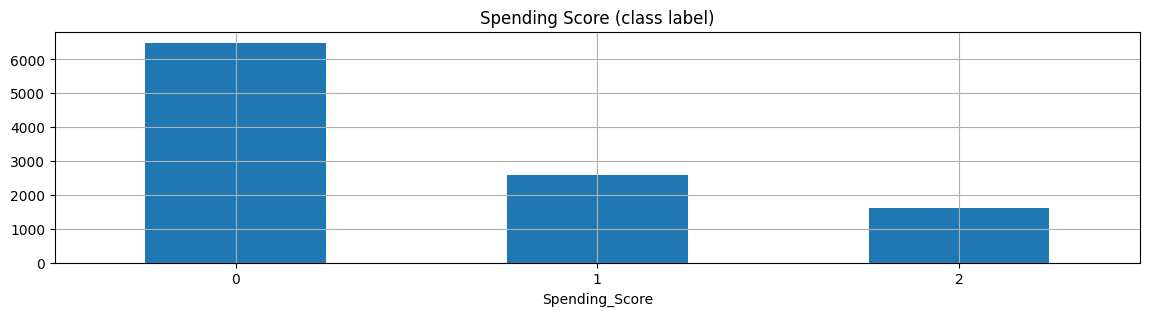

In [6]:
# Check if class label is balanced
dataframe['Spending_Score'].value_counts().plot(kind='bar', title='Spending Score (class label)', rot=0, grid=True, figsize=(14, 3))
plt.show()

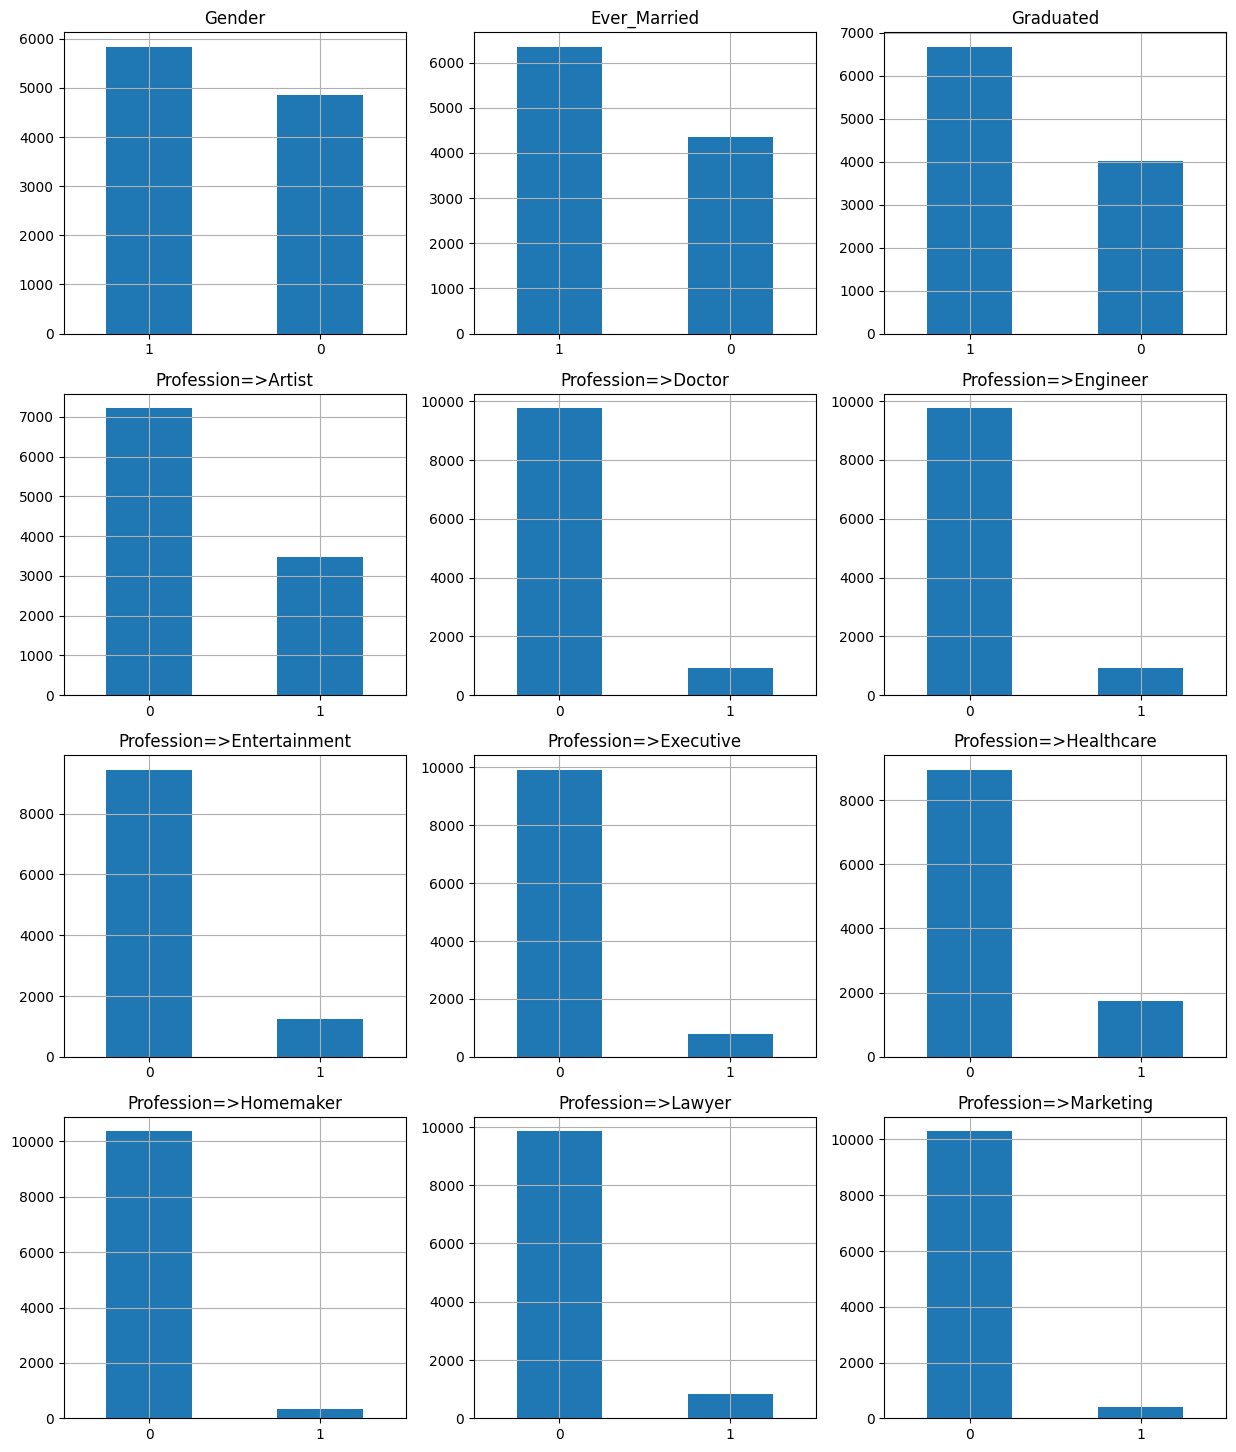

In [7]:
### Visualize the other columns
categorical_columns = list(dataframe.columns)
categorical_columns.remove('Age')
categorical_columns.remove('Work_Experience')
categorical_columns.remove('Family_Size')
categorical_columns.remove('Spending_Score')

## Plot categorical columns
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 3, figsize=(15, 18))
i_column = 0 # specifies the column
i_row = 0 # specifies the row
axes = [ax0, ax1, ax2, ax3]
for column in categorical_columns:

  # reset column index and increment row index
  if i_column == 3:
    i_column = 0
    i_row += 1

  # Plot the graph
  dataframe[column].value_counts().plot(kind='bar', ax=axes[i_row][i_column], title=column, rot=0, grid=True, xlabel='')

  # Increment column index
  i_column += 1

plt.show()

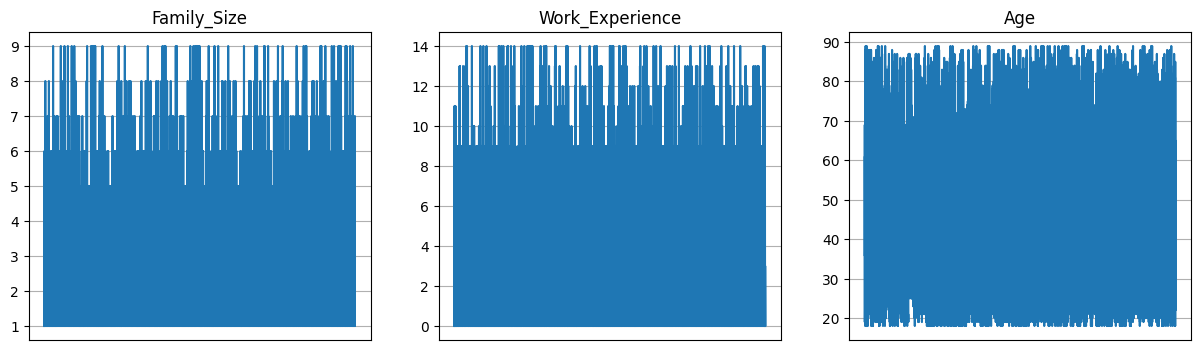

In [8]:
continuous_columns = ['Family_Size', 'Work_Experience', 'Age']

# Plot continuous columns
fig, (ax0) = plt.subplots(1, 3, figsize=(15, 4))
for index, column in enumerate(continuous_columns):
  dataframe[column].plot(kind='line', title=column, grid=True, ax=ax0[index], xticks=[])
plt.show()

In [9]:
# Separate data
features = dataframe.drop('Spending_Score', axis = 1)
label = dataframe['Spending_Score']
print(f"Features: {features.values.shape}\nLabel: {label.values.shape}")

Features: (10695, 15)
Label: (10695,)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


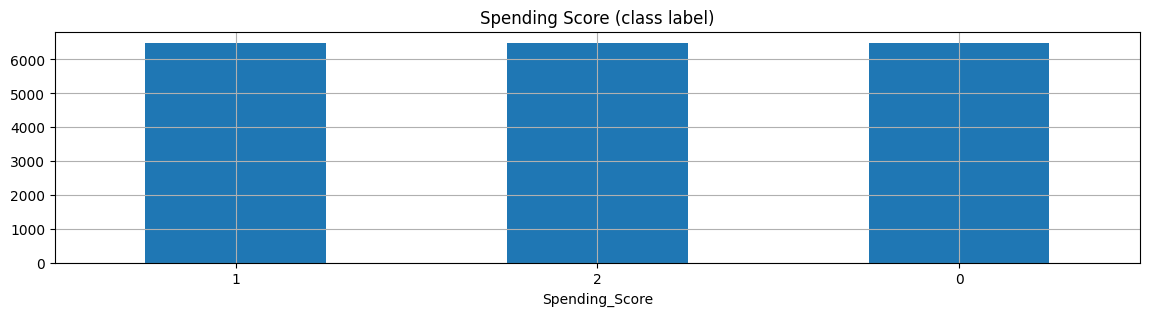

Features: (19488, 15)
Label: (19488,)


In [10]:
# Balance Data
from imblearn.over_sampling import KMeansSMOTE
over_sampler = KMeansSMOTE(k_neighbors=4, cluster_balance_threshold=0.1)
features, label = over_sampler.fit_resample(features, label)

label.value_counts().plot(kind='bar', title='Spending Score (class label)', rot=0, grid=True, figsize=(14, 3))
plt.show()

print(f"Features: {features.values.shape}\nLabel: {label.values.shape}")

In [11]:
# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size = 0.3, stratify=label.values)

# Apply Feature Scaling
from sklearn.preprocessing import StandardScaler
training_scaler = StandardScaler()
testing_scaler = StandardScaler()

X_train = training_scaler.fit_transform(X_train)
X_test = testing_scaler.fit_transform(X_test)

# Change np.arrays to torch tensors and move them to the device being used
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

print(X_train.shape, X_train.dtype)
print(X_test.shape, X_test.dtype)

torch.Size([13641, 15]) torch.float32
torch.Size([5847, 15]) torch.float32


In [13]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [14]:
# Prepare numbers for training data vs validation data splitting
total_rows = X_train.shape[0]
val_rows = int(total_rows * 0.3)
training_rows = total_rows - val_rows

# Validation data
X_val = X_train[:val_rows]
y_val = y_train[:val_rows]

# New training data
X_train = X_train[:training_rows]
y_train = y_train[:training_rows]

print(f"Total Rows: {total_rows}, Training Rows: {training_rows}, Validation Rows: {val_rows}\n")
print(f"Training Features:   {X_train.shape}, Training Labels: {y_train.shape}")
print(f"Validation Features: {X_val.shape}, Validation Labels: {y_val.shape}")

Total Rows: 13641, Training Rows: 9549, Validation Rows: 4092

Training Features:   torch.Size([9549, 15]), Training Labels: torch.Size([9549])
Validation Features: torch.Size([4092, 15]), Validation Labels: torch.Size([4092])


In [15]:
# Prepare data in Dataset for DataLoader
train_dataset = CustomDataset(X=X_train, y=y_train)

# Load data into Data Loaders with batching
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [69]:
# Prepare Model
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchmetrics.classification import Accuracy, ConfusionMatrix, F1Score, Precision, Recall

class Neural_Network(nn.Module):
  def __init__(self, num_input_features, num_classes):
    super().__init__()

    # Initialize Layers
    self._hidden_layer_1 = nn.Linear(in_features=num_input_features, out_features=42)
    self._hidden_layer_2 = nn.Linear(in_features=42, out_features=84)
    self._hidden_layer_3 = nn.Linear(in_features=84, out_features=168)
    self._output_layer = nn.Linear(in_features=168, out_features=num_classes)

    # Initialize Metrics
    self._accuracy_score = Accuracy(task="multiclass", num_classes=num_classes)
    self._confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
    self._f1_score = F1Score(task="multiclass", num_classes=num_classes)
    self._precision_score = Precision(task="multiclass", average='macro', num_classes=num_classes)
    self._recall_score = Recall(task="multiclass", average='macro', num_classes=num_classes)

  def forward(self, x):
    x = F.relu( self._hidden_layer_1(x) )
    x = F.relu( self._hidden_layer_2(x) )
    x = F.relu( self._hidden_layer_3(x) )
    output = F.log_softmax(self._output_layer(x), dim=1)
    return output

  def train_model(self, training_data, validation_data, optimizer, loss_function, epochs):
    # Initialize stat storage: per epoch and per batch
    training_losses_per_batch = []
    training_accuracies_per_batch = []
    training_losses_per_epoch = []
    training_accuracies_per_epoch = []
    val_losses = []
    val_accuracies = []

    for i in range(epochs):
      batch_number = 1
      ## Train Model on batches and validate model after each training batch

      # To get the average accuray per epoch
      num_batches = len(training_data)
      accuracy_per_epoch = 0
      loss_per_epoch = 0

      for X_train_batch, y_train_batch in training_data:
        X_train_batch, y_train_batch = X_train_batch, y_train_batch
        self.train()

        #1# Forward pass
        training_output = self.forward(X_train_batch) # returns arrays of num_classes outputs
        predictions = torch.argmax(training_output, dim=1)

        #2# Calculate training loss and accuracy
        training_loss = loss_function(training_output, y_train_batch)
        training_accuracy_score = self._accuracy_score(predictions, y_train_batch).item()

        loss_per_epoch += training_loss.item()
        accuracy_per_epoch += training_accuracy_score

        #3# Backward pass
        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()

        # Store Stats
        training_losses_per_batch.append(training_loss.item())
        training_accuracies_per_batch.append(training_accuracy_score)

      # Get the average loss and accuracy across all the epochs
      loss_per_epoch /= num_batches
      accuracy_per_epoch /= num_batches

      # Get the loss and accuracies across all batches
      training_losses_per_epoch.append(loss_per_epoch)
      training_accuracies_per_epoch.append(accuracy_per_epoch)

      ## Validate Model on entire val_dataset after gradient update
      self.eval()
      with torch.no_grad():
        # Predict on validation data
        val_output = self.forward(validation_data[0])
        val_predictions = torch.argmax(val_output, dim=1)

        # Calculate val loss and accuracy
        val_loss = loss_function(val_output, validation_data[1])
        val_accuracy_score = self._accuracy_score(val_predictions, validation_data[1])

        # Store validation stats
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy_score.item())

        print(f"Epoch {i+1} - loss: {training_loss:.4f} - accuracy: {accuracy_per_epoch:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy_score:.4f}")

    history = {
        'training_losses_per_batch': training_losses_per_batch, 'training_accuracies_per_batch': training_accuracies_per_batch,
        'training_losses_per_epoch': training_losses_per_epoch, 'training_accuracies_per_epoch': training_accuracies_per_epoch,
        'val_losses': val_losses, 'val_accuracies': val_accuracies,
        'training_loss': training_losses_per_epoch[-1], 'training_accuracy': training_accuracies_per_epoch[-1],
        'val_loss': val_losses[-1], 'val_accuracy': val_accuracies[-1],
        }
    return history

  def predict(self, X, y_true, loss_function):
    self.eval()
    with torch.no_grad():
      # Predict on X_test
      output = self.forward(X)

      predictions = torch.argmax(output, dim=1)

      # Calculate loss on Test Data
      correct = (predictions == y_true).to(float)
      manual_loss = 1 - (torch.count_nonzero(correct) / len(correct))
      function_loss = loss_function(output, y_true)

      # Calculate Accuracy on Testing Data
      accuracy = self._accuracy_score(predictions, y_true)

      # Metrics
      confusion_matrix = self._confusion_matrix(predictions, y_true)
      f1 = self._f1_score(predictions, y_true)
      recall = self._recall_score(predictions, y_true)
      precision = self._precision_score(predictions, y_true)

      stats = {
              "manual_loss": manual_loss, "function_loss": function_loss, "accuracy": accuracy,
              "f1_score": f1, "recall_score": recall, "precision_score": precision, "confusion_matrix": confusion_matrix
              }
      return stats

In [70]:
# Initialize model, optimizer, and loss function
model = Neural_Network(num_input_features=15, num_classes=3)

# Initialize optimizer and loss function
adam_optimizer = optim.Adam(params=model.parameters(), lr=0.0005)
negative_log_likelihood = nn.NLLLoss()

In [71]:
# Train Neural Network
training = model.train_model(
    training_data=train_loader, validation_data=[X_val, y_val],
    optimizer=adam_optimizer, loss_function=negative_log_likelihood, epochs=50
    )

Epoch 1 - loss: 0.5251 - accuracy: 0.7725 - val_loss: 0.4321 - val_accuracy: 0.8438
Epoch 2 - loss: 0.3885 - accuracy: 0.8560 - val_loss: 0.3845 - val_accuracy: 0.8653
Epoch 3 - loss: 0.2676 - accuracy: 0.8686 - val_loss: 0.3667 - val_accuracy: 0.8761
Epoch 4 - loss: 0.2306 - accuracy: 0.8747 - val_loss: 0.3537 - val_accuracy: 0.8785
Epoch 5 - loss: 0.4553 - accuracy: 0.8768 - val_loss: 0.3443 - val_accuracy: 0.8790
Epoch 6 - loss: 0.3505 - accuracy: 0.8798 - val_loss: 0.3369 - val_accuracy: 0.8827
Epoch 7 - loss: 0.3854 - accuracy: 0.8785 - val_loss: 0.3320 - val_accuracy: 0.8873
Epoch 8 - loss: 0.3718 - accuracy: 0.8808 - val_loss: 0.3283 - val_accuracy: 0.8866
Epoch 9 - loss: 0.2443 - accuracy: 0.8822 - val_loss: 0.3292 - val_accuracy: 0.8881
Epoch 10 - loss: 0.1964 - accuracy: 0.8848 - val_loss: 0.3232 - val_accuracy: 0.8844
Epoch 11 - loss: 0.5328 - accuracy: 0.8827 - val_loss: 0.3216 - val_accuracy: 0.8913
Epoch 12 - loss: 0.2514 - accuracy: 0.8840 - val_loss: 0.3249 - val_accura

In [72]:
# Test Neural Network
testing = model.predict(X=X_test, y_true=y_test, loss_function=negative_log_likelihood)

In [73]:
# Print results
print(f"Training Accuracy:   {training['training_accuracy']}")
print(f"Validation Accuracy: {training['val_accuracy']}")
print(f"Testing Accuracy:    {testing['accuracy']}\n")

print(f"Training Loss (NLL):     {training['training_loss']}")
print(f"Validation Loss (NLL):   {training['val_loss']}")
print(f"Testing Loss (Accuracy): {testing['manual_loss']}")
print(f"Testing Loss (NLL):      {testing['function_loss']}\n")

# Print Metrics for Test Results
print("Pred  class 0  class 1  class 2")
print("Actual")
print(f"{testing['confusion_matrix']}\n")
print(f"F1_Score: {testing['f1_score']}")
print(f"Recall Score: {testing['recall_score']}")
print(f"Precision Score: {testing['precision_score']}\n")

Training Accuracy:   0.8975461409395973
Validation Accuracy: 0.9032257795333862
Testing Accuracy:    0.8809645771980286

Training Loss (NLL):     0.289302788374808
Validation Loss (NLL):   0.27458998560905457
Testing Loss (Accuracy): 0.11903542280197144
Testing Loss (NLL):      0.3416682183742523

Pred  class 0  class 1  class 2
Actual
tensor([[1613,  249,   86],
        [  72, 1768,  110],
        [  61,  118, 1770]])

F1_Score: 0.8809645771980286
Recall Score: 0.8809511661529541
Precision Score: 0.8840780258178711



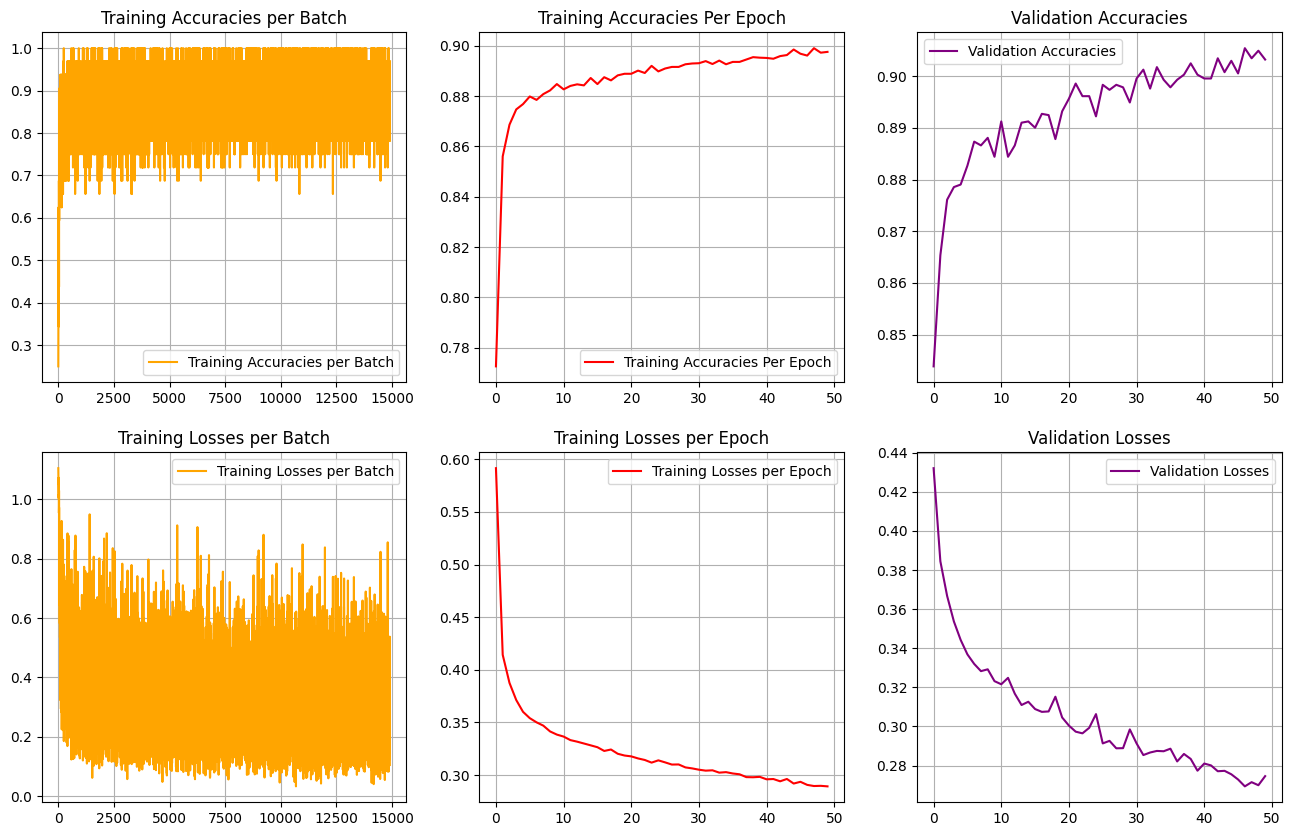

In [75]:
# Helper Function
def plot_training_results(ax, per_epoch, per_batch, validation, title1, title2, title3):
  ax[0].plot(per_batch, color = 'orange')
  ax[0].legend([title2])
  ax[0].grid(True)
  ax[0].set_title(title2)

  ax[1].plot(per_epoch, color = 'red')
  ax[1].legend([title1])
  ax[1].grid(True)
  ax[1].set_title(title1)

  ax[2].plot(validation, color = 'purple')
  ax[2].legend([title3])
  ax[2].grid(True)
  ax[2].set_title(title3)

# Plot results
fig, (ax1, ax2) = plt.subplots(2,3,figsize=(16,10))

plot_training_results(ax=ax1,
             per_epoch=training['training_accuracies_per_epoch'], title1='Training Accuracies Per Epoch',
             per_batch=training['training_accuracies_per_batch'], title2='Training Accuracies per Batch',
             validation=training['val_accuracies'],  title3='Validation Accuracies')

plot_training_results(ax=ax2,
                      per_epoch=training['training_losses_per_epoch'], title1="Training Losses per Epoch",
                      per_batch=training['training_losses_per_batch'], title2="Training Losses per Batch",
                      validation=training['val_losses'], title3='Validation Losses')

plt.show()